# REGIONAL Ascending 101 Stack and Time Series

## Goal:  explore use of netCDF and dask to avoid overloading laptop memory.

### Take 2: after talking with Anthony & Don. Make following changes. Store interferograms as dimension coorindates rather than data_vars. Keep in lon, lat to avoid geocoding grid issues and follow netCDF conventions. Take advantage of Dask chunking to run inversion on entire dataset.

NOTES:
- data covers approx 3x3degree aread (300^2 km^2)
- unwrapped at ~90m ground resultion & filtered
- geocoded at 30m posting to match processing DEM (10800x 10802 pixels --> 446Mb per array)
- looks.py to reduce resoltion (8alks, 8rlks) --> (1350x 1350 pixels --> 7Mb per array)

In [1]:
import numpy as np
import os
import glob

import geopandas as gpd
import pandas as pd

import rasterio
import pyproj
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as pltdate

%config InlineBackend.figure_format = 'retina'

%matplotlib inline
#%matplotlib notebook
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.size'] = '16'
%qtconsole

In [3]:
# Directory of coseismic interferograms
datadir = '/Users/scott/Dropbox/SEGMEnT/netCDFs'
auxfiles = '/Users/scott/Dropbox/SEGMEnT/auxfiles'

enuFile = auxfiles + '/enu_regional.nc' #pre-convert los into cartesian multipliers
swbdFile = auxfiles + '/swbd_regional.nc'
demFile = auxfiles + '/dem_regional.nc'

epsg = 32736  #UTM 36S WGS84
wavelength = 55.46576 #NOTE: netCDFs pre-converted from radians to line-of-sight [mm]

In [4]:
os.chdir(datadir)
files = glob.glob('int*')
files.sort()
print('#pairs: ', len(files))

#pairs:  119


In [5]:
# Organize dataframe summary of netCDF files
pairs = [x[:-3] for x in files]
dfAll = pd.DataFrame(pairs, columns=['file'])
dfAll['primary'] = pd.to_datetime(dfAll.file.str[4:12], format='%Y%m%d')
dfAll['secondary'] = pd.to_datetime(dfAll.file.str[13:], format='%Y%m%d')
dfAll['dt'] = dfAll.primary - dfAll.secondary
dfAll.head()

,file,primary,secondary,dt
0,int_20141117_20141012,2014-11-17,2014-10-12,36 days
1,int_20141117_20141024,2014-11-17,2014-10-24,24 days
2,int_20141129_20141012,2014-11-29,2014-10-12,48 days
3,int_20141129_20141024,2014-11-29,2014-10-24,36 days
4,int_20141129_20141117,2014-11-29,2014-11-17,12 days


In [6]:
# Some basic info about the set
dates = np.unique(np.append(dfAll.primary.values, dfAll.secondary.values))
#print(dfB.dateStr.iloc[0], ' to ', dfB.dateStr.iloc[-1])
print(len(dfAll), ' Interferograms')
print(len(dates), 'Dates')
print('First Date: ', dfAll.secondary.iloc[0])
print('Second Date: ', dfAll.primary.iloc[-1])

119  Interferograms
82 Dates
First Date:  2014-10-12 00:00:00
Second Date:  2017-04-11 00:00:00


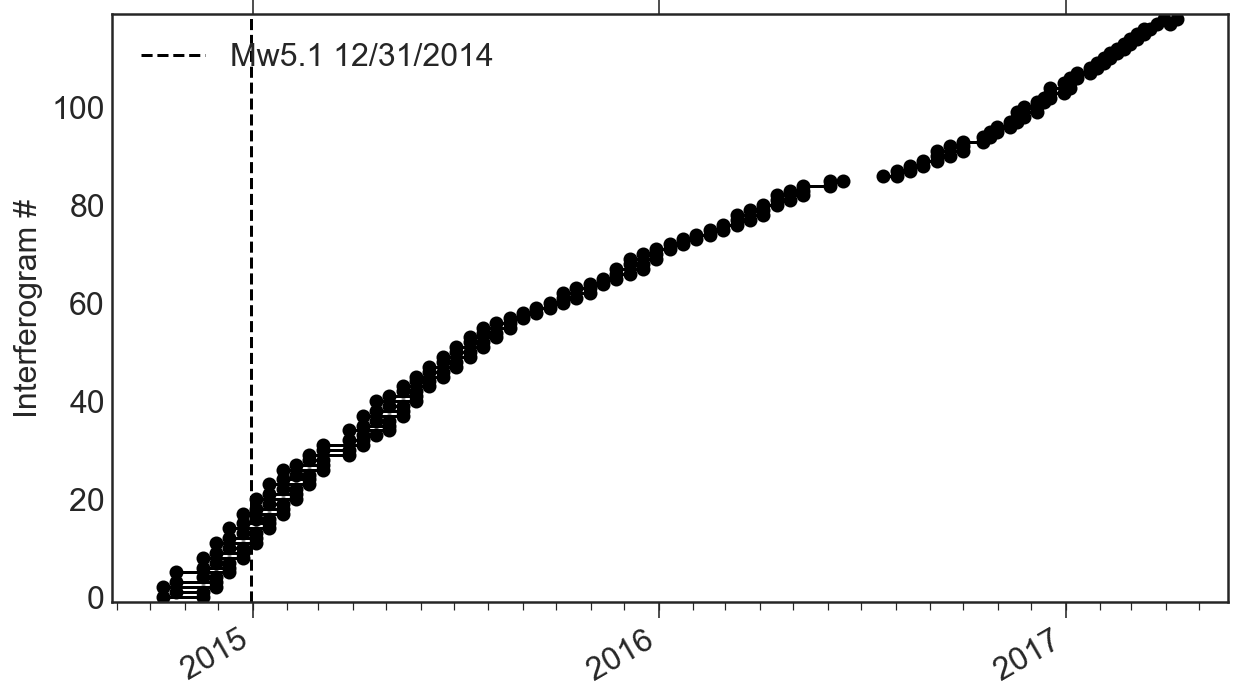

In [7]:
#from matplotlib.ticker import FixedLocator
from matplotlib.dates import MonthLocator, DateFormatter
fig, ax = plt.subplots(figsize=(10,6))
for i,row in dfAll.iterrows():
    plt.plot([row.secondary, row.primary], [i,i],  'ko-')
    midx = row.secondary + (row.primary - row.secondary)/2
    #plt.text(midx, i+0.25, int(row.bperp))

eq = pd.to_datetime('20141231', format='%Y%m%d')
plt.axvline(eq, linestyle='dashed', color='k', label='Mw5.1 12/31/2014')
plt.ylim(-1,i+1)
plt.ylabel('Interferogram #')
plt.legend(loc='upper left')
#plt.xticks(dates)
#ax.xaxis.set_major_formatter(DateFormatter("%m/%d/%Y")) #too many dates!
#fig.autofmt_xdate()

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.tick_params(axis='x', which='major', bottom=True, length=8)
plt.tick_params(labelleft=True, bottom=True, top=True, right=True, left=True)
fig.autofmt_xdate()

In [8]:
# Count number of pairs for each date
def summarize_dates(df):
    dfDates = pd.DataFrame(index=np.unique(df.primary.append(df.secondary)), columns=['count'])
    dfDates['p_pairs'] = df.groupby('primary').secondary.count()
    dfDates['s_pairs'] = df.groupby('secondary').primary.count()
    dfDates = dfDates.fillna(0)
    dfDates['count'] = dfDates.p_pairs + dfDates.s_pairs
    return dfDates

In [9]:
summarize_dates(dfAll)

,count,p_pairs,s_pairs
2014-10-12,2.0,0.0,2.0
2014-10-24,3.0,0.0,3.0
2014-11-17,5.0,2.0,3.0
2014-11-29,6.0,3.0,3.0
2014-12-11,6.0,3.0,3.0
2014-12-23,6.0,3.0,3.0
2015-01-04,6.0,3.0,3.0
2015-01-16,6.0,3.0,3.0
2015-01-28,6.0,3.0,3.0
2015-02-09,5.0,3.0,2.0


In [11]:
# Epicenter of Mw 5.1 earthquake on 12/31/3014
epi_segment = (33.836, -9.87) 
proj4str = '+init=EPSG:{}'.format(epsg)
utm36s = pyproj.Proj(proj4str)
xcen,ycen = utm36s(*epi_segment)
print(xcen,ycen)
lon,lat = utm36s(xcen,ycen,inverse=True)
print(lon,lat)

591661.1098421689 8908846.078686059
33.836 -9.870000000000003


In [12]:
import sys
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [13]:
show_mem_usage()

0.030MB


# Sentinel-1 timeseries with xarray

In [27]:
def preproc(ds):
    ''' 
    not sure how to directly extract file name... temp fix here
    function designed to correct metadata and add additional stuff to attr
    '''
    del ds['crs']
    ifg = ds.attrs['history'].split(',')[0][-24:-3]   
    return ds.rename(dict(Band1=ifg))


ds = xr.open_mfdataset(os.path.join(datadir, '*nc'), 
                       #concat_dim='pair', #doesn't work automatically, see to_array() call below
                       preprocess=preproc, 
                       decode_cf=False,
                       autoclose=True)

# Add some attributes common to the set
setMetaData = dict(description='SEGMeNT S1 A101 Timeseries',
                   created=pd.to_datetime('today'),
                   author='Scott Henderson',
                   ISCE='2.1.0')
ds.attrs = setMetaData
ds = ds.to_array(dim='pair', name='stack')

In [28]:
ds

<xarray.DataArray 'stack' (pair: 119, lat: 1350, lon: 1350)>
dask.array<stack, shape=(119, 1350, 1350), dtype=float32, chunksize=(1, 1350, 1350)>
Coordinates:
  * lat      (lat) float64 -11.75 -11.75 -11.75 -11.74 -11.74 -11.74 -11.74 ...
  * lon      (lon) float64 32.5 32.5 32.51 32.51 32.51 32.51 32.52 32.52 ...
  * pair     (pair) <U21 'int_20141117_20141012' 'int_20141117_20141024' ...
Attributes:
    description:  SEGMeNT S1 A101 Timeseries
    created:      2017-11-02 00:00:00
    author:       Scott Henderson
    ISCE:         2.1.0

<xarray.DataArray 'stack' (lat: 1350, lon: 1350)>
dask.array<getitem, shape=(1350, 1350), dtype=float32, chunksize=(1350, 1350)>
Coordinates:
  * lat      (lat) float64 -11.75 -11.75 -11.75 -11.74 -11.74 -11.74 -11.74 ...
  * lon      (lon) float64 32.5 32.5 32.51 32.51 32.51 32.51 32.52 32.52 ...
    pair     <U21 'int_20141117_20141012'
Attributes:
    description:  SEGMeNT S1 A101 Timeseries
    created:      2017-11-02 00:00:00
    author:       Scott Henderson
    ISCE:         2.1.0


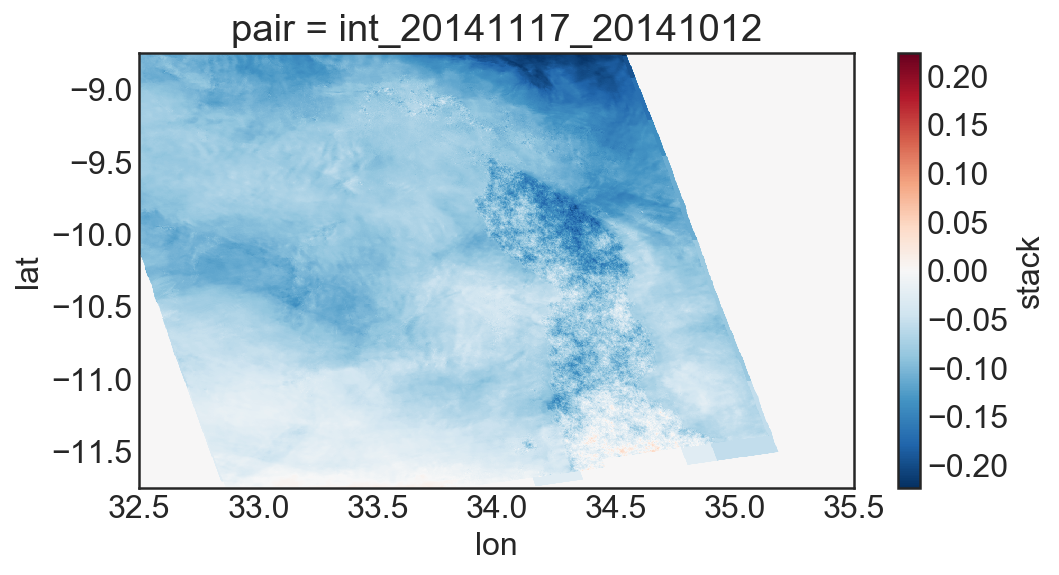

In [33]:
# Plot particular interferogram
ifg = ds.isel(pair=0)
ifg = ds.sel(pair='int_20141117_20141012') #equivalent
print(ifg)
ifg.plot()

<xarray.Dataset>
Dimensions:  (lat: 1350, lon: 1350)
Coordinates:
  * lat      (lat) float64 -11.75 -11.75 -11.75 -11.74 -11.74 -11.74 -11.74 ...
  * lon      (lon) float64 32.5 32.5 32.51 32.51 32.51 32.51 32.52 32.52 ...
Data variables:
    crs      |S1 b''
    Band1    (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 0 0 0 ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.1.4, released 2017/06/23
    history:             Thu Nov 02 16:39:36 2017: GDAL CreateCopy( swbd_regi...


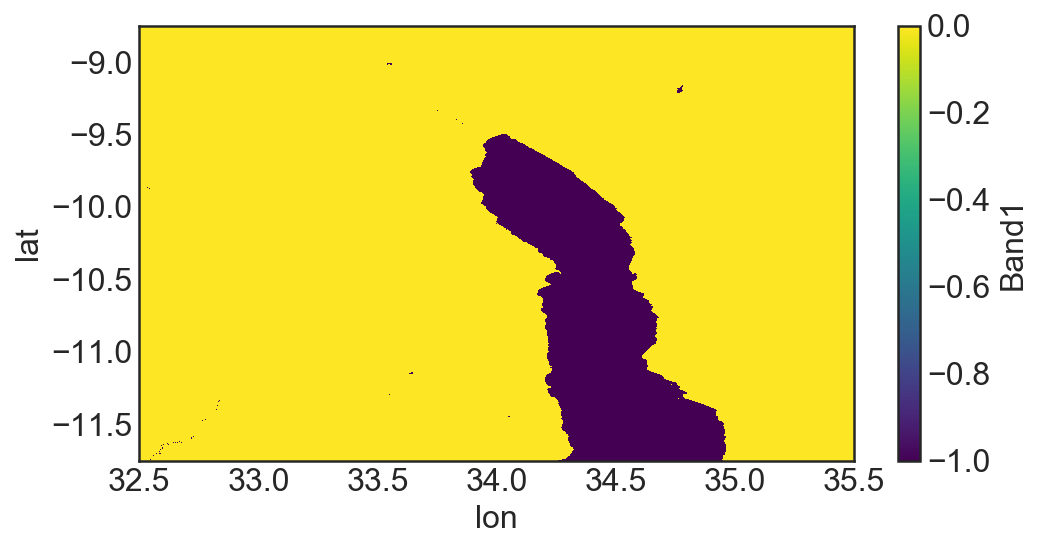

In [34]:
# Get Water Mask
#dsMask = xr.open_dataset(swbdFile) #casts as float64 
dsMask = xr.open_dataset(swbdFile, decode_cf=False)
print(dsMask)
dsMask.Band1.plot()
#NOTE: loads as float64 even though dtype on disk is Byte... something weird happened in creation

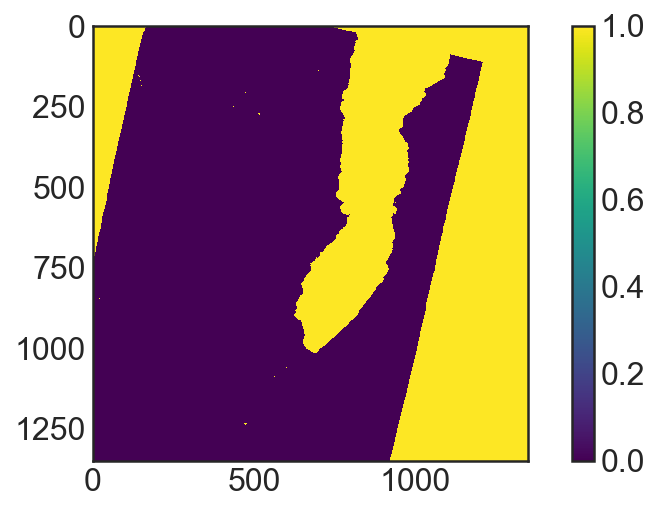

In [35]:
water = (dsMask.Band1.values != 0)
border = np.isnan(ifg.values)
invalid = (ifg.values == 0.0)
mask = water + border + invalid

plt.imshow(mask) #NOTE: appears inverted due to lack of coordinates
plt.colorbar()
#plt.title(mask)

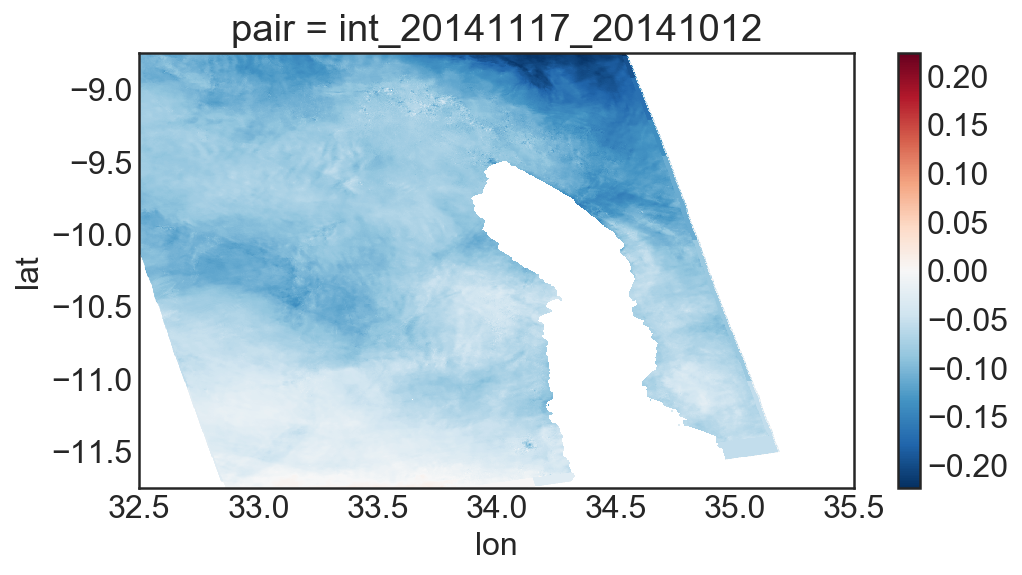

In [38]:
# Add mask as coordinate array to interferogram, calculate mean, plot
ifg.coords['mask'] = (('lat', 'lon'), mask)
ifg.where(ifg.mask == False).plot()

In [43]:
print('wrong mean:\n', ifg.mean().load()) #zeros not set as nans, so best to flag as nans upon loading
print('right mean:\n', ifg.where(ifg.mask == False).mean().load())

wrong mean:
 <xarray.DataArray 'stack' ()>
array(-0.05983607843518257, dtype=float32)
Coordinates:
    pair     <U21 'int_20141117_20141012'
right mean:
 <xarray.DataArray ()>
array(-0.08043879270553589, dtype=float32)
Coordinates:
    pair     <U21 'int_20141117_20141012'


In [44]:
show_mem_usage()
# NOTE: not sure why _111 and other outputs are being stored?... figures?

['water'] 1.823MB
['border'] 1.823MB
['invalid'] 1.823MB
['mask'] 1.823MB
7.330MB


In [45]:
# Add common mask to dataset coords
ds.coords['mask'] = (('lat', 'lon'), mask)

/Users/scott/miniconda3/envs/pnwinsar/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


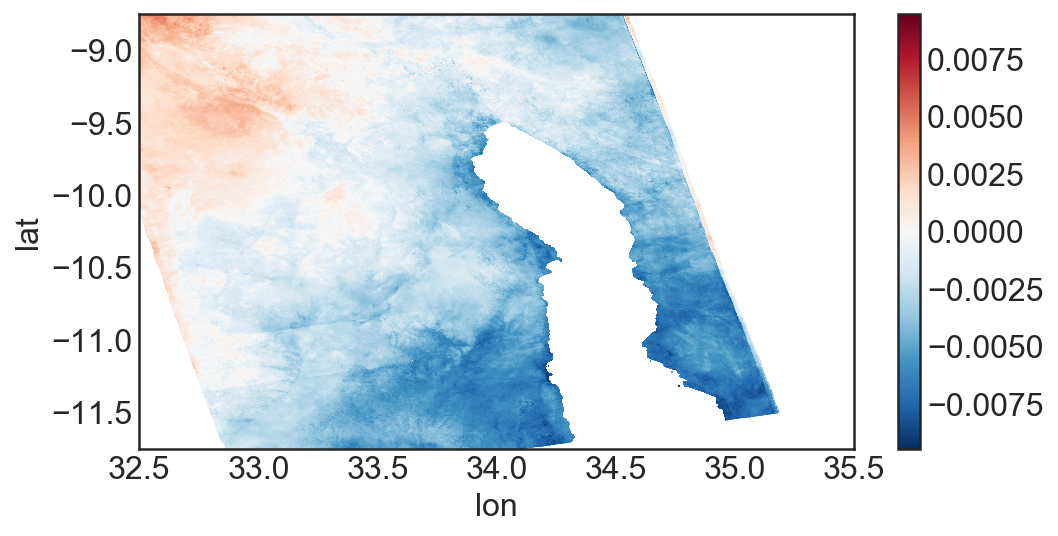

In [115]:
# Arithmetic stack
stack = ds.where(ds.mask == False).mean(dim='pair').load() # only prepares computation
stack.plot() #NOTE: distinct ramp across scene.

In [259]:
# Question: how to take advantage of multiple cores w/ dask:
#https://github.com/geohackweek/tutorial_contents/blob/master/nDarrays/notebooks/ndarrays_intro.ipynb

#import dask
#from multiprocessing.pool import ThreadPool
#dask.set_options(pool=ThreadPool(4))

# Doesn't seem to be working...
#from dask.diagnostics import ProgressBar
#with ProgressBar():
#    ds.where(ds.mask == False).mean()

In [52]:
# Convert coords to lat, lon
# NOTE: might be a better way to do this via rasterio
lons = ds.coords['lon'].values
lats = ds.coords['lat'].values
eastings,junk = utm36s(lons, lats[0]*np.ones_like(lons))
junk,northings = utm36s(lons[0]*np.ones_like(lats), lats)

In [90]:
# Extract subsets of data
print('total images=', ds.shape[0])
# 1) First 30 images

# iterate over interferograms as DataArrays
#pairs = ds.coords['pair'].values

dsSubset = ds.isel(pair=slice(0,30))
print('subset images=', dsSubset.shape[0])

total images= 119
subset images= 30


In [92]:
# 2) Drop a problematic date
dfAll = pd.DataFrame(dict(pair=pairs))
dfAll['primary'] = pd.to_datetime(dfAll.pair.str[4:12], format='%Y%m%d')
dfAll['secondary'] = pd.to_datetime(dfAll.pair.str[13:], format='%Y%m%d')
dfAll['dt'] = dfAll.primary - dfAll.secondary
dfAll.head()

badDate = '2014-11-17'
keep = (dfAll.primary != badDate) & (dfAll.secondary != badDate)

subset = dfAll[keep]

dsSubset = ds.sel(pair=list(subset.pair))
print('subset images=', dsSubset.shape[0])

subset images= 114


Text(0.5,1,'int_20141117_20141012')

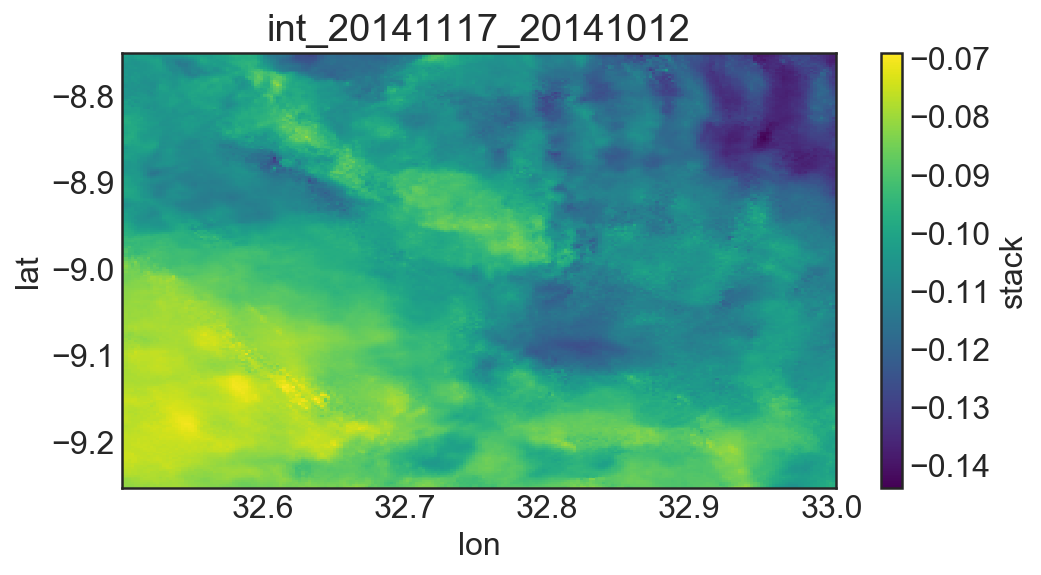

In [126]:
# 3) Extract subregion based on coordinates:
# here 50x50km box in upper left corner
x0 = float(ds.lon[0].values)
y0 = float(ds.lat[-1].values) #NOTE: -1 for upper left
width = 0.5 #degrees
height = 0.5
region = dict(lon=slice(x0, x0+width),
              lat=slice(y0-height, y0)) #note minimum val first, but lat decreasing to south

dsSubset = ds.sel(**region)

ifg = 'int_20141117_20141012'
dsSubset.sel(pair=ifg).plot()
plt.title(ifg)

(-9.25180555555555, -8.75180555555555)

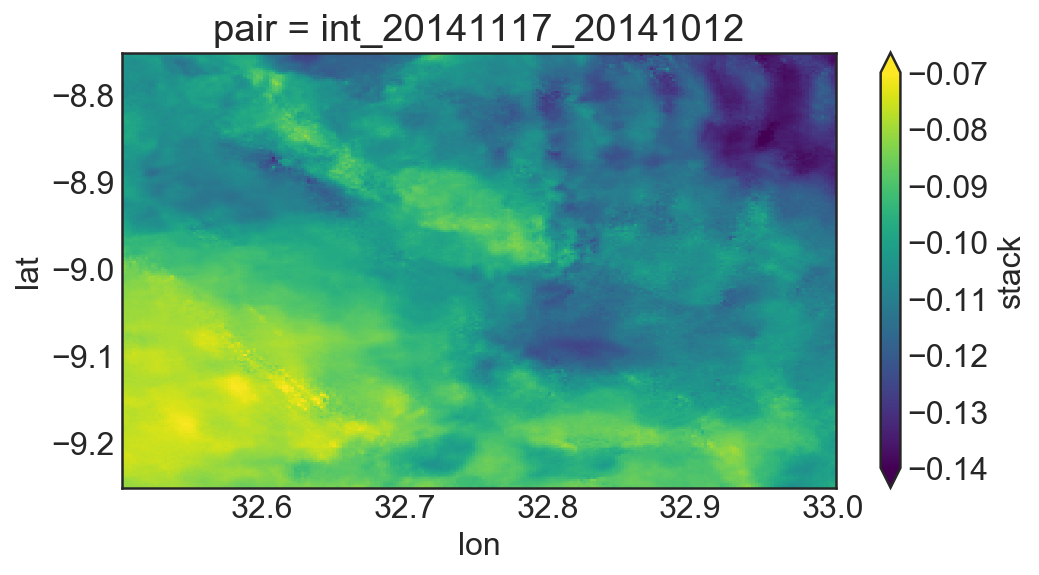

In [129]:
# Check subsetting... cool.
ds.sel(pair='int_20141117_20141012').plot(cmap='viridis', vmin=-0.14, vmax=-0.07)
plt.xlim(x0, x0+0.5)
plt.ylim(y0-0.5, y0)

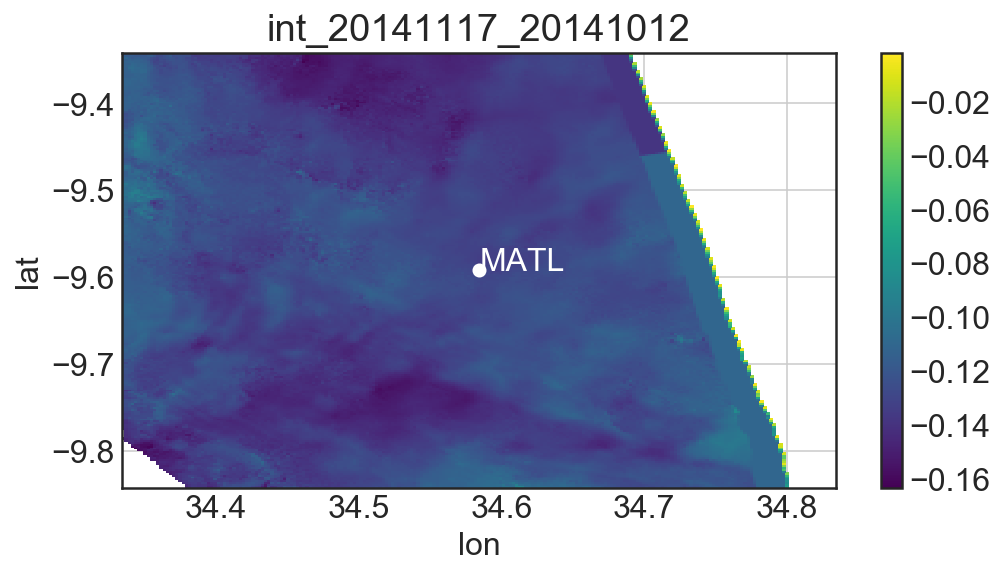

In [135]:
# 3) Extract subregion around point of interest
pMATL = (34.5847, -9.592)
xcen,ycen = pMATL #Good get more exact...
pad = 0.25
# here 50x50km box in upper left corner
region = dict(lon=slice(xcen-pad, xcen+pad),
              lat=slice(ycen-pad, ycen+pad))

dsSubset = ds.sel(**region)

ifg = 'int_20141117_20141012'
dsSubset.sel(pair=ifg).where(dsSubset.mask == False).plot()
plt.plot(xcen,ycen,'wo')
plt.text(xcen,ycen,'MATL',color='w')
plt.title(ifg)
#plt.grid(True)
# NOTE: add reference box in matplotlib

In [145]:
# Run time series for this subset
xref = 34.4
yref = -9.5
pad = 0.05
reference = dict(lon=slice(xref-pad, xref+pad),
                 lat=slice(yref-pad, yref+pad))

# Normalize all subset scenes relative to reference zone
#refMean = dsSubset.sel(**reference).mean() #Gotcha
dsSubset.sel(**reference).groupby('pair').mean()
#refMean['int_20141117_20141012'].data #how to actually get these values?
#refmean.to_dataframe()
#refVals = refMean.to_array().values 
plt.plot(refVals, 'ko')
plt.xlabel('interferogram #')
plt.ylabel('mean of reference patch [m]')
plt.axhline()
plt.figure()
plt.hist(refVals)
plt.axvline(color='r')
plt.ylabel('# interferograms')
plt.xlabel('mean of reference patch [m]')

NameError: name 'refVals' is not defined

Text(0.5,0,'mean of target patch [m]')

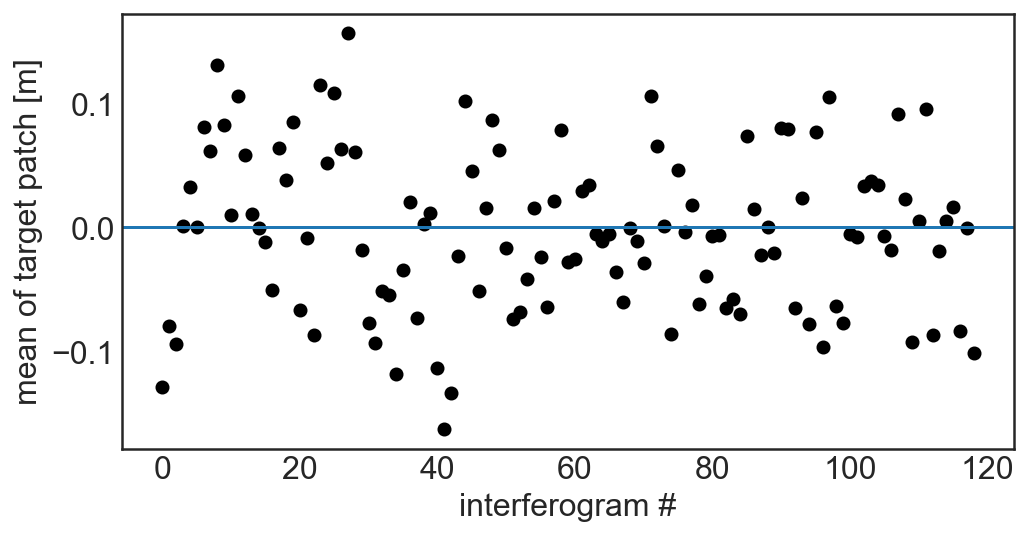

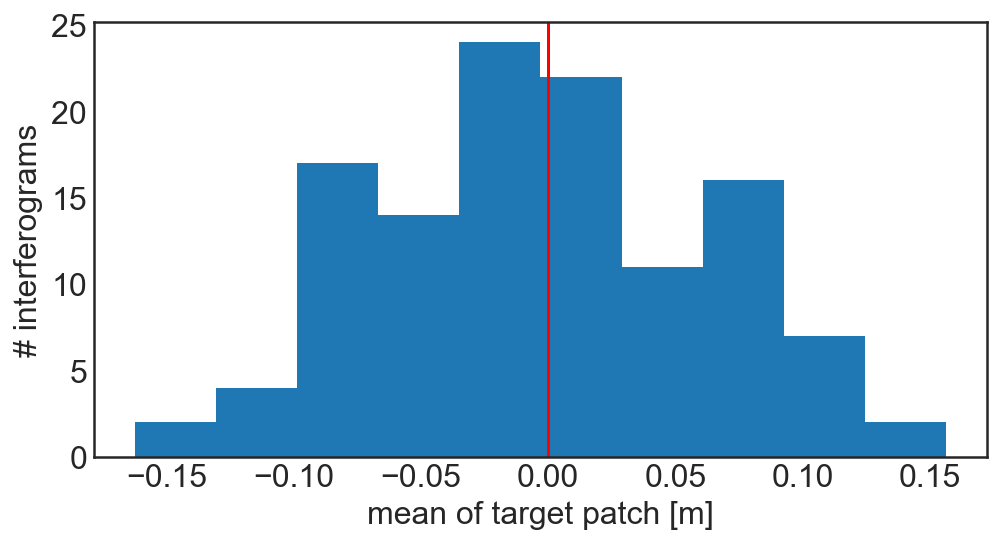

In [379]:
# Plot un-normalized value of MATL over time
target = dict(x=slice(xcen-pad, xcen+pad),
              y=slice(ycen-pad, ycen+pad))

# Normalize all subset scenes relative to reference zone
targetMean = dsSubset.sel(**target).mean()

targetVals = targetMean.to_array().values 
plt.plot(targetVals, 'ko')
plt.xlabel('interferogram #')
plt.ylabel('mean of target patch [m]')
plt.axhline()
plt.figure()
plt.hist(targetVals)
plt.axvline(color='r')
plt.ylabel('# interferograms')
plt.xlabel('mean of target patch [m]')

Text(0.5,0,'normalized target patch [m]')

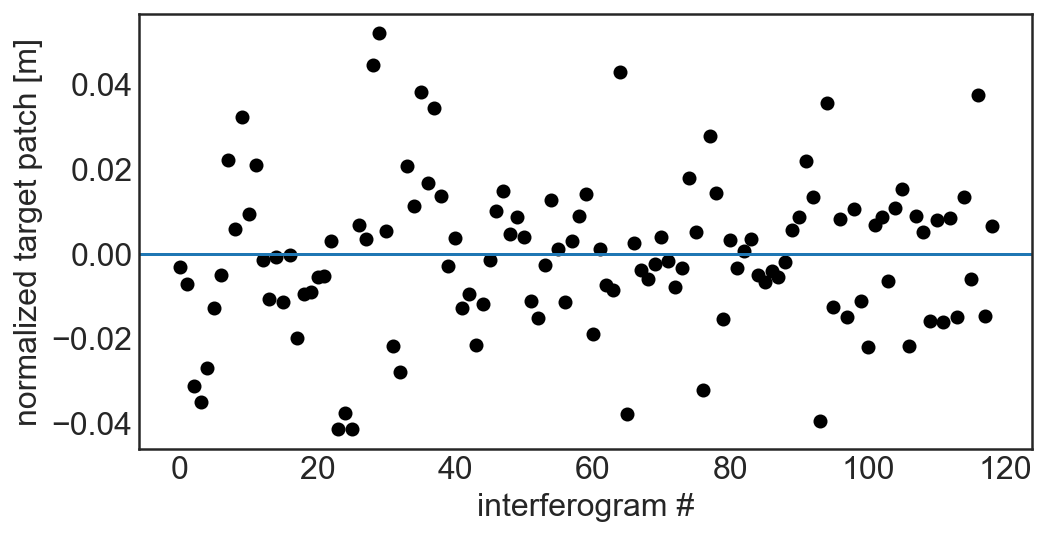

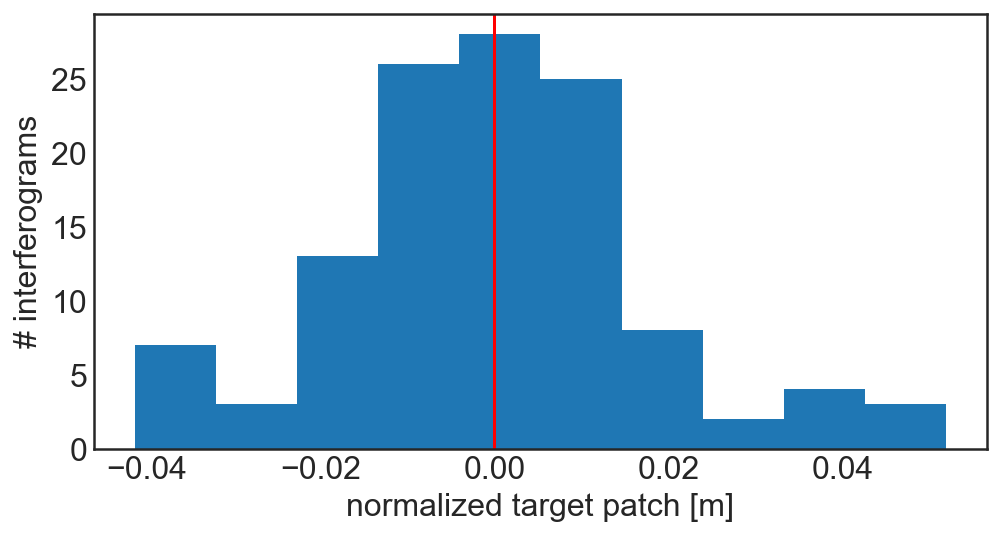

In [380]:
plt.plot(targetVals-refVals, 'ko')
plt.xlabel('interferogram #')
plt.ylabel('normalized target patch [m]')
plt.axhline()
plt.figure()
plt.hist(targetVals-refVals)
plt.axvline(color='r')
plt.ylabel('# interferograms')
plt.xlabel('normalized target patch [m]')

In [684]:
df = dfAll.query('primary < "2016-06-01" ') 
dfDates = summarize_dates(df)

print(len(df), ' Interferograms')
print(len(dfDates), 'Dates')
print('First Date: ', dfDates.index[0])
print('Last Date: ', dfDates.index[-1])

dsSub = ds[list(df.pair)]

pMATL = (34.5847, -9.592)
xcen,ycen = utm36s(*pMATL)
pad = 25e3
# here 50x50km box in upper left corner
region = dict(x=slice(xcen-pad, xcen+pad),
              y=slice(ycen-pad, ycen+pad))

dsSubset = dsSub.sel(**region)


84  Interferograms
47 Dates
First Date:  2014-10-12 00:00:00
Last Date:  2016-05-10 00:00:00


In [658]:
# Calculate timeseries on subset
# Prep Inversion
# Now overdetermined problem
# Create G matrix (many ways to do this...)
m_ints = len(dsSubset.data_vars)
n_date = len(dfDates)
n_rows, n_cols = dsSubset.mask.shape #number of rows and columns in each interferogram

G = np.zeros((m_ints,n_date)) #i,j row,col indexing

sD = pd.Series(np.arange(n_date), index=dfDates.index) #Date lookup table

for i,row in df.iterrows():
    j = sD[row.primary]
    k = sD[row.secondary]
    G[i,j] = 1 #Note:  fix first date to be zero?
    G[i,k] = -1

In [659]:
G

array([[-1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [660]:
# Get numpy data cube (stack of interferograms)
stack = dsSubset.where(dsSubset.mask == False).to_array().values
print(stack.shape)
d_flat = stack.reshape(stack.shape[0], -1)
print(d_flat.shape)

(84, 204, 205)
(84, 41820)


In [661]:
# Run Inversion w/ augmented matrix to fix first date to zero
# Since it's a subset load everything into memory. NOTE: think about ways to do this more
# efficiently for entire array

G = np.matrix(G)
d = np.matrix(d_flat)
n_pix = d.shape[-1]

F = np.matrix(np.zeros(n_date))
F[0,0] = 1
h = np.matrix(np.zeros(n_pix)) #fixes initial position to zero...

Gaug = np.r_[np.c_[G.T*G, F.T], np.c_[F, np.matrix(0)]]
daug = np.r_[G.T*d, h]

maug = Gaug.I *daug
m_est = maug[:-1]

d_est = G*m_est

In [662]:
# Convert from Matrix to Array type for further analysis
# Cumulative deformation at each date
m_ts = np.array(m_est)
m_ts = m_ts.reshape(n_date, n_rows, n_cols)

# Reconstructed interferograms
d_ts = np.array(d_est)
d_ts = d_ts.reshape(m_ints, n_rows, n_cols)

In [663]:
show_mem_usage()

['mm'] 7.344MB
['border'] 1.836MB
['outSwath'] 1.836MB
['mask'] 1.836MB
['water'] 1.836MB
['_111'] 14.688MB
['swath'] 1.836MB
['_179'] 1.836MB
['_183'] 1.836MB
['_196'] 1.836MB
['_201'] 1.836MB
['_203'] 1.836MB
['invalid'] 1.836MB
['_404'] 28.103MB
['stack'] 28.103MB
['d'] 28.103MB
['daug'] 16.059MB
['maug'] 16.059MB
['d_est'] 28.103MB
187.694MB


In [664]:
# Insert timeseries into new dataset (now with time coordinate)
timeStamps = dfDates.index

#coords = dsSubset.coords 
#coords['time'] = timeStamps #NOTE: this also addes time coord to dsSubset
# NOTE: probably a better way to do this...
tmp = dsSubset.copy(deep=True)
coords = tmp.coords
coords['time'] = timeStamps 

data = {'displacement': (['time','y','x'], m_ts) }

dsTS = xr.Dataset(data, coords)

In [665]:
dsTS

<xarray.Dataset>
Dimensions:       (time: 47, x: 205, y: 204)
Coordinates:
  * x             (x) float64 6.49e+05 6.492e+05 6.495e+05 6.497e+05 ...
  * y             (y) float64 8.914e+06 8.915e+06 8.915e+06 8.915e+06 ...
    mask          (y, x) bool True True False False False False False False ...
  * time          (time) datetime64[ns] 2014-10-12 2014-10-24 2014-11-17 ...
Data variables:
    displacement  (time, y, x) float64 nan nan 7.506e-16 7.639e-16 7.606e-16 ...

In [666]:
# Slice in time at particular pixel location
#range=slice('2014-01-01', '2015-01-01') 
time_series = dsTS.sel(x=xcen, y=ycen, method='nearest') #add time=range to subset

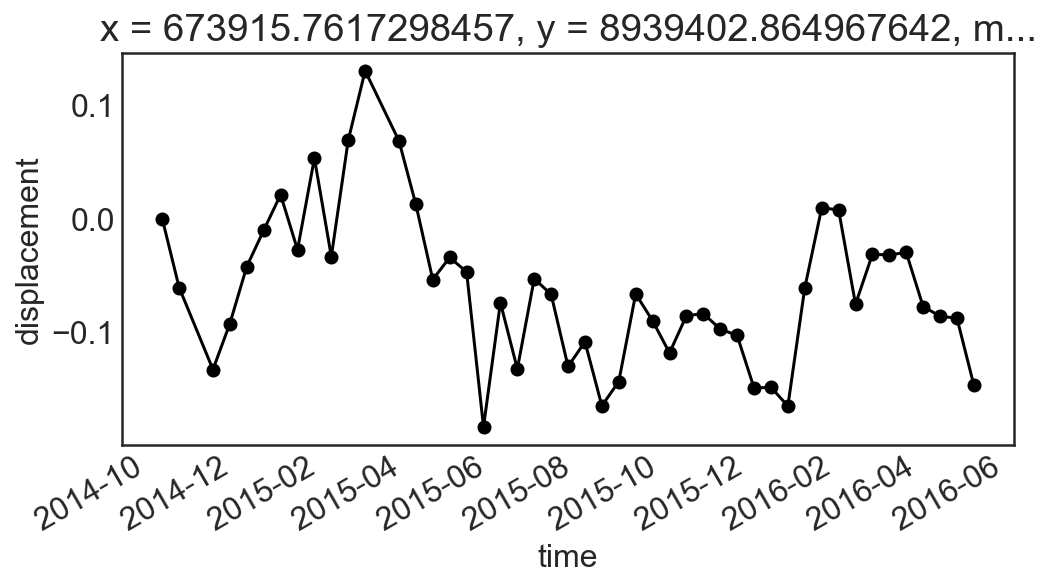

In [667]:
time_series.displacement.plot(color='k', marker='o')

### NOTEs:

- data was not normalized. check by plotting timeseries of reference region (should be about 0). or plot mean of every scene (probably not zero)
- how to do common reference for large region? set upper left corner box to zero *after ramp removal (so that scene is 'flattened')? Should do network ramp removal for consistency like with GIAnT
- add synthetic signal to make sure inversion is working as expected...
- can do resampling when timeseries gets long: sst_monthly = sst.resample('MS', dim='time', how='mean')

In [670]:
# Save time series netCDF
#dsTS.to_netcdf('output/timeseries_MATL.nc')

#test = xr.open_dataset('output/timeseries_MATL.nc')
#test #all good

In [671]:
# More Index / Selection
dsTS.displacement.isel(time=0, x=0, y=0) #integer index

dsTS.displacement.loc['2014-10-24']

<xarray.DataArray 'displacement' (y: 204, x: 205)>
array([[      nan,       nan, -0.077137, ...,       nan,       nan,       nan],
       [      nan,       nan, -0.079343, ...,       nan,       nan,       nan],
       [      nan, -0.07476 , -0.076685, ...,       nan,       nan,       nan],
       ..., 
       [-0.053161, -0.05701 , -0.058617, ...,       nan,       nan,       nan],
       [-0.055199, -0.05787 , -0.059201, ...,       nan,       nan,       nan],
       [-0.055169, -0.056922, -0.058595, ...,       nan,       nan,       nan]])
Coordinates:
  * x        (x) float64 6.49e+05 6.492e+05 6.495e+05 6.497e+05 6.499e+05 ...
  * y        (y) float64 8.914e+06 8.915e+06 8.915e+06 8.915e+06 8.915e+06 ...
    mask     (y, x) bool True True False False False False False False False ...
    time     datetime64[ns] 2014-10-24

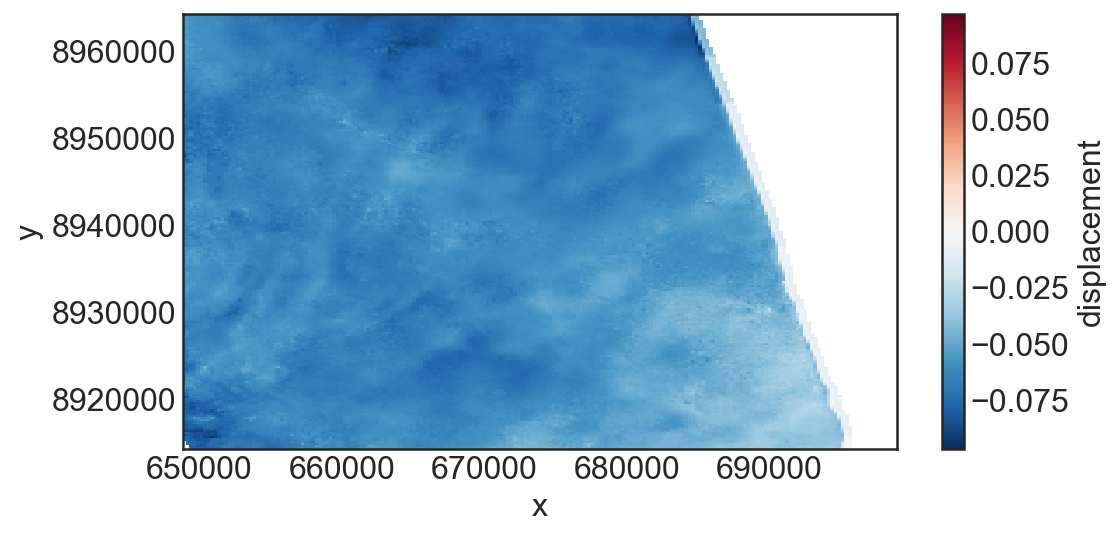

In [672]:
# Re-generate data from model (specific interferogram)
primary = dsTS.displacement.loc['2014-10-24']
secondary = dsTS.displacement.loc['2014-10-12']
ifg = primary - secondary
ifg.plot()

Text(0.5,1,'Arithmetic Stack')

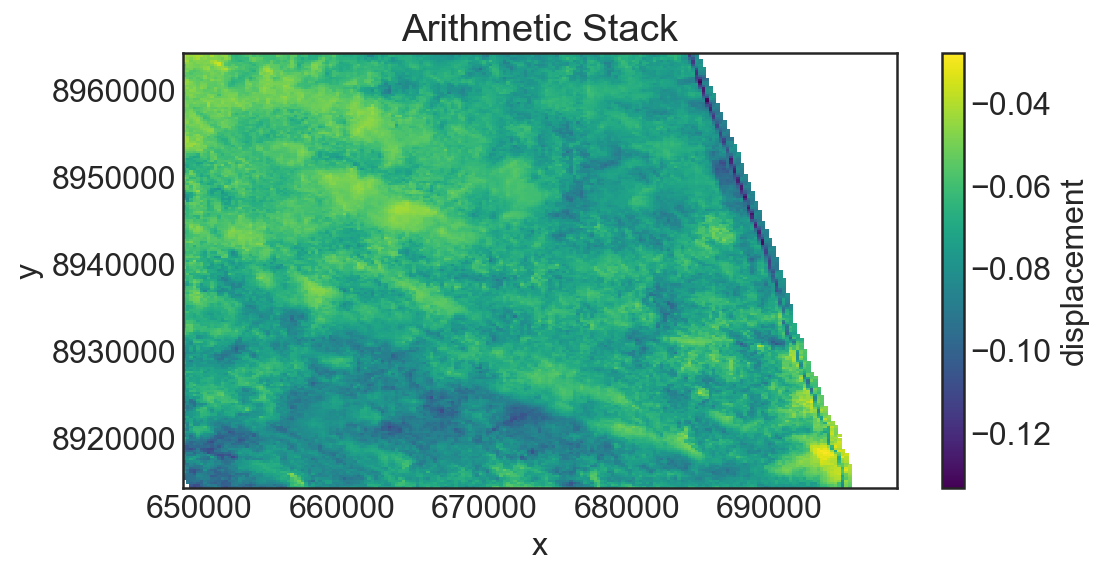

In [673]:
# Simple arithmetic stack
dsTS.displacement.mean(dim='time').plot()
plt.title('Arithmetic Stack')

Text(0,0.5,'mean of subset [m]')

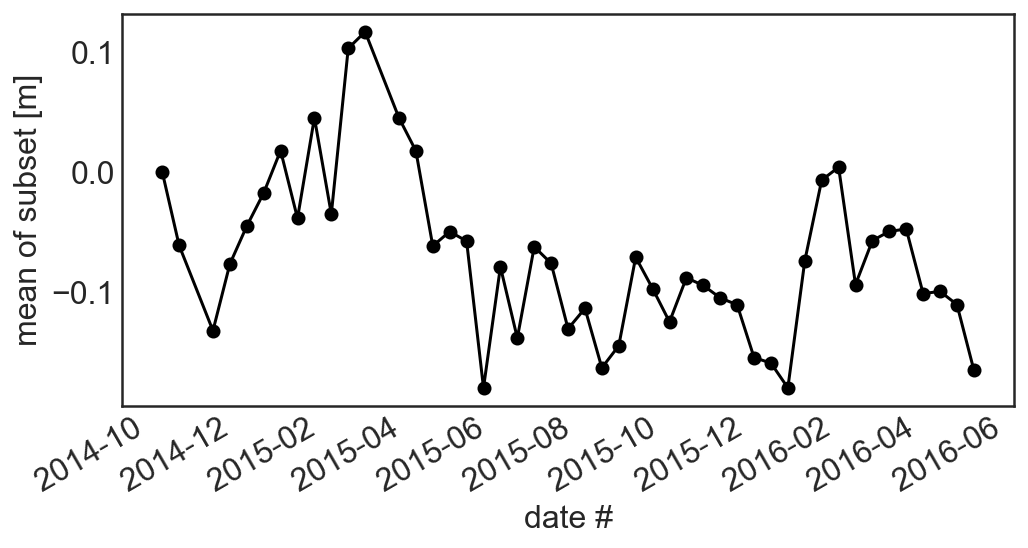

In [674]:
dsTS.displacement.groupby('time').mean().plot(marker='o', color='k')
plt.xlabel('date #')
plt.ylabel('mean of subset [m]')

# NOTE average of 200x200 pixels looks nearly identical to single pixel...
# NOTE also due to gdal_calc command, postive implies range increase (subsidence)
# linear subsidence trend possibly coming from lack of ramp removal?
# NOTE: is it possible entire area east of lake experiences hydrological seasonal change, in which
# case we'd have to expand subset and use a reference patch that is farther from MATL target...

In [675]:
# Repeat inversion, first normalizing by reference patch
# Same G matrix, different d

# normalize
xref = 655000.0
yref = 8950000.0
pad = 2.5e3
reference = dict(x=slice(xref-pad, xref+pad),
                 y=slice(yref-pad, yref+pad))

# Normalize all subset scenes relative to reference zone
refMean = dsSubset.sel(**reference).mean()

dsNorm = (dsSubset - refMean)*1e3 #normalize & convert to mm

#dsSubset['int_20160510_20160428'][0,0].load() #-0.00844989251345396
#refMean['int_20160510_20160428'].load() #-0.06146474307402969
#dsNorm['int_20160510_20160428'][0,0].load() #53.014850560575724


# Get numpy data cube (stack of interferograms)
stack = dsNorm.where(dsNorm.mask == False).to_array().values
print(stack.shape)
d_flat = stack.reshape(stack.shape[0], -1)
print(d_flat.shape)



(84, 204, 205)
(84, 41820)


In [676]:
# Run Inversion w/ augmented matrix to fix first date to zero
# Since it's a subset load everything into memory. NOTE: think about ways to do this more
# efficiently for entire array

G = np.matrix(G)
d = np.matrix(d_flat)
n_pix = d.shape[-1]

F = np.matrix(np.zeros(n_date))
F[0,0] = 1
h = np.matrix(np.zeros(n_pix)) #fixes initial position to zero...

Gaug = np.r_[np.c_[G.T*G, F.T], np.c_[F, np.matrix(0)]]
daug = np.r_[G.T*d, h]

maug = Gaug.I *daug
m_est = maug[:-1]

d_est = G*m_est

In [677]:
# Convert from Matrix to Array type for further analysis
# Cumulative deformation at each date
m_ts = np.array(m_est)
m_ts = m_ts.reshape(n_date, n_rows, n_cols)

# Reconstructed interferograms
d_ts = np.array(d_est)
d_ts = d_ts.reshape(m_ints, n_rows, n_cols)

In [679]:
# Insert timeseries into new dataset (now with time coordinate)
timeStamps = dfDates.index

#coords = dsSubset.coords
#coords['time'] = timeStamps

data = {'displacement': (['time','y','x'], m_ts) }

dsTS = xr.Dataset(data, coords)

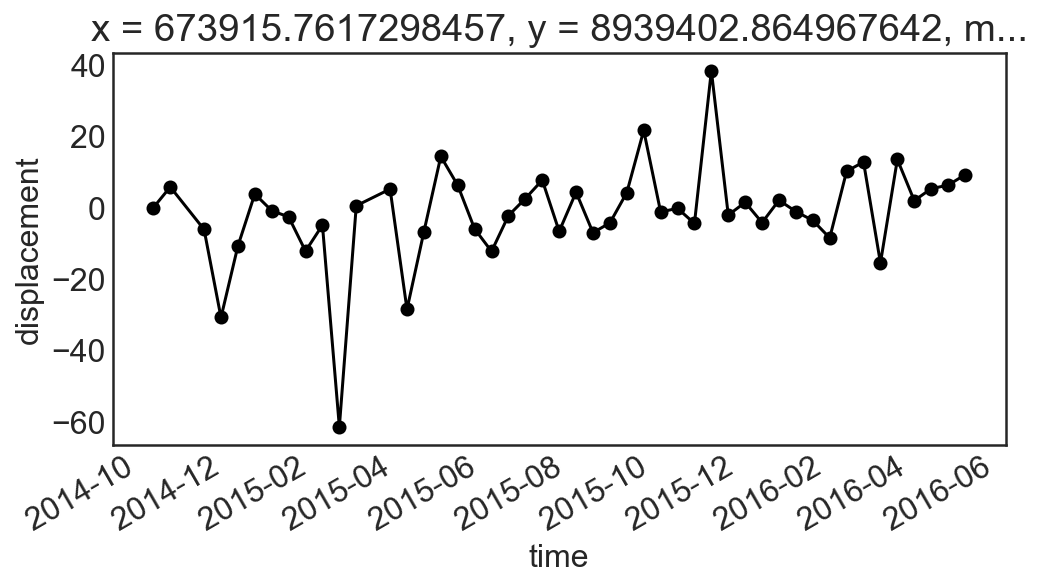

In [680]:
# Slice in time at particular pixel location
#range=slice('2014-01-01', '2015-01-01') 
time_series = dsTS.sel(x=xcen, y=ycen, method='nearest') #add time=range to subset
time_series.displacement.plot(color='k', marker='o')

Text(0,0.5,'Displacement (mm)')

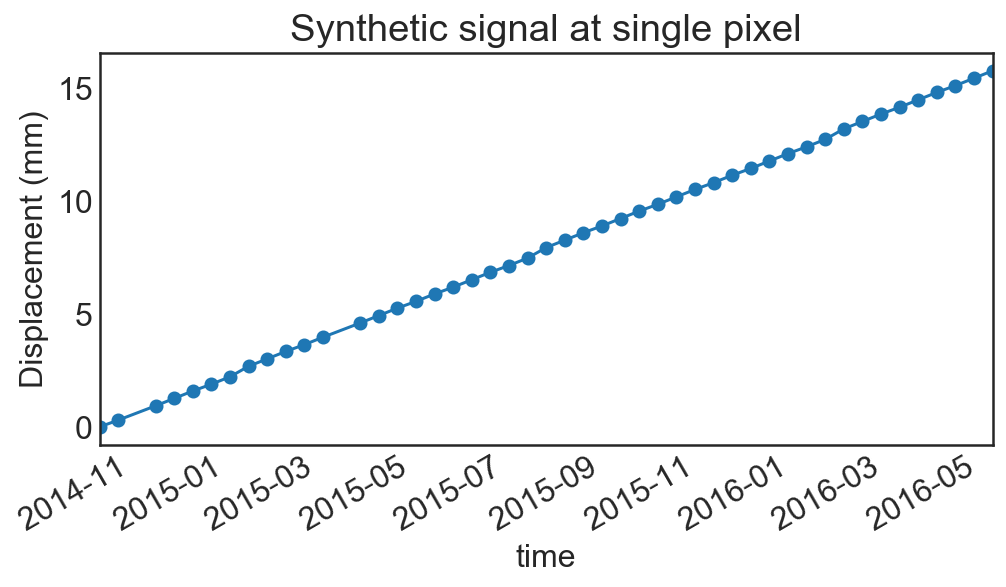

In [681]:
# Add a 1D synthetic linear signal (single pixel) at MATL signal to see how well it's recovered
rate = 10.0 #mm/yr
# careful... times get converted to ns by default 3.154e16 ns per year

start = dsTS.indexes['time'][0]
end = dsTS.indexes['time'][-1]
timespan = (end - start).days / 365

# NOTE: could just generate samples at dsTS dates, but here creating smoother signal, then
# later sampling at specific dates
samples = pd.to_datetime(np.linspace(start.value, end.value, 100)) 
signal = rate*((samples - samples[0]).days / 365)

#resample signal at specific S1 dates
series = pd.Series(signal, samples)
synthetic = series.reindex(dsTS.indexes['time'], method='nearest')
synthetic.plot(marker='o')
plt.title('Synthetic signal at single pixel')
plt.ylabel('Displacement (mm)')

In [686]:
# Add Synthetic to xarray
dsSyn = dsSubset.copy() #NOTE: why does dsSubset have 'time dimension?...'

#NOTE: probably a better way to do this:
# NOTE: how to get row,col of matching coordinate?
#match = dsSyn.sel(x=xcen, y=ycen, method='nearest')
#dsSyn.loc[:, [match.coords['x'].values, match.coords['y'].values] ]

# whoops, a bit trickier than above b/c synthetic data needs to difference this signal between dates
# very similar to 'wrapped' versus unwrapped signal
# for now add signal to upper left pixel for simplicity
d_syn = np.dot(G,synthetic) # what you would see in each interferogram

In [694]:
# Multiple Datasets has disadvantage of indexing (can't slice through interferograms w/ current set-up)
# Here is a work around:
stack = dsSyn.to_array(dim='ifg') #stacks data variables to data array
# len(dsSyn.data_vars) i=84
# dsSyn.dims x=205, y=204
dsSyn.sel(x=xcen, y=ycen, method='nearest')

AttributeError: 'Dataset' object has no attribute 'iloc'